In [1]:
import os
import json
from collections import defaultdict
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
dist_from_end = 10000000
phase_dirs = ['../phased_ihart.ms2_quads_del']
ped_files = ['../../DATA/ihart.ms2/ihart.ped.quads.ped']

In [3]:


# From GRCh38.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh38.p13
chrom_lengths = {
	'1': 248956422,
	'2': 242193529,
	'3': 198295559,
	'4': 190214555,
	'5': 181538259,
	'6': 170805979,
	'7': 159345973,
	'8': 145138636,
	'9': 138394717,
	'10': 133797422,
	'11': 135086622,
	'12': 133275309,
	'13': 114364328,
	'14': 107043718,
	'15': 101991189,
	'16': 90338345,
	'17': 83257441,
	'18': 80373285,
	'19': 58617616,
	'20': 64444167,
	'21': 46709983,
	'22': 50818468,
#	'X': 156040895,
#	'Y': 57227415
}


In [4]:
# pull ped data
def pull_phenotype_ped(ped_file):
	sample_to_sex = dict()
	sample_to_affected = dict()
	parents_to_children = defaultdict(list)
	with open(ped_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			sample_to_sex[pieces[1]] = pieces[4]
			sample_to_affected[pieces[1]] = pieces[5]
			if pieces[2] != '0' and pieces[3] != '0':
				parents_to_children[(pieces[3], pieces[2])].append(pieces[1])
	return sample_to_affected, sample_to_sex, parents_to_children

sample_to_affected = dict()
for ped_file in ped_files:
	s_to_a, _, _ = pull_phenotype_ped(ped_file)
	sample_to_affected.update(s_to_a)

In [5]:
# pull crossover information, preferentially pull sibpairs with same phenotype
quad_to_crossovers = defaultdict(list)
already_included = set()
for phase_dir in phase_dirs:
	print('loading phase for', phase_dir)
	for file in sorted(os.listdir(phase_dir)):
		if file.endswith('.crossovers.json'):
			with open('%s/%s' % (phase_dir, file), 'r') as f:
				cos = json.load(f)
				child1, child2 = cos[0]['child']
				if len(cos)>=250:
					#print('Are they related?', cos[0]['child'][0], cos[0]['child'][1], file)
					pass
				elif child1 in already_included or child2 in already_included:
					#print('Child(ren) already included in analysis', cos[0]['child'][0], cos[0]['child'][1], file)
					pass
				elif child1 in sample_to_affected and child2 in sample_to_affected and sample_to_affected[child1]==sample_to_affected[child2]:
					for co in cos:
						co['num_affected'] = int(sample_to_affected[child1]=='2') + int(sample_to_affected[child2]=='2')
						quad_to_crossovers[tuple(co['child'])].append(co)
					already_included.add(co['child'][0])
					already_included.add(co['child'][1])

for phase_dir in phase_dirs:
	print('loading phase for', phase_dir)
	for file in sorted(os.listdir(phase_dir)):
		if file.endswith('.crossovers.json'):
			with open('%s/%s' % (phase_dir, file), 'r') as f:
				cos = json.load(f)
				child1, child2 = cos[0]['child']
				if len(cos)>=250:
					#print('Are they related?', cos[0]['child'][0], cos[0]['child'][1], file)
					pass
				elif child1 in already_included or child2 in already_included:
					#print('Child(ren) already included in analysis', cos[0]['child'][0], cos[0]['child'][1], file)
					pass
				elif child1 in sample_to_affected and child2 in sample_to_affected:
					for co in cos:
						co['num_affected'] = int(sample_to_affected[child1]=='2') + int(sample_to_affected[child2]=='2')
						quad_to_crossovers[tuple(co['child'])].append(co)
					already_included.add(co['child'][0])
					already_included.add(co['child'][1])
            
print('children with phase information', 2*len(quad_to_crossovers))
print('num_affected 0=%d, 1=%d, 2=%d' % (len([x for x in quad_to_crossovers.keys() if int(sample_to_affected[x[0]]=='2')+int(sample_to_affected[x[1]]=='2')==0]),
										 len([x for x in quad_to_crossovers.keys() if int(sample_to_affected[x[0]]=='2')+int(sample_to_affected[x[1]]=='2')==1]),
										 len([x for x in quad_to_crossovers.keys() if int(sample_to_affected[x[0]]=='2')+int(sample_to_affected[x[1]]=='2')==2])))


loading phase for ../phased_ihart.ms2_quads_del
loading phase for ../phased_ihart.ms2_quads_del
children with phase information 1806
num_affected 0=41, 1=80, 2=782


In [10]:
tel_count = defaultdict(int)
for quad, cos in quad_to_crossovers.items():
    for co in cos:
        if co['chrom']==1:
            is_in_tel = (co['end_pos']<=dist_from_end) #or (co['start_pos']>=(chrom_lengths[str(co['chrom'])]-dist_from_end))
            tel_count[(co['is_mat'], co['num_affected'], is_in_tel)] += 1
        

In [11]:
print(tel_count)

defaultdict(<class 'int'>, {(True, 2, False): 5069, (False, 2, True): 456, (False, 2, False): 2803, (True, 2, True): 280, (True, 0, False): 264, (False, 0, True): 18, (False, 0, False): 151, (True, 0, True): 8, (True, 1, False): 515, (False, 1, False): 299, (True, 1, True): 33, (False, 1, True): 43})


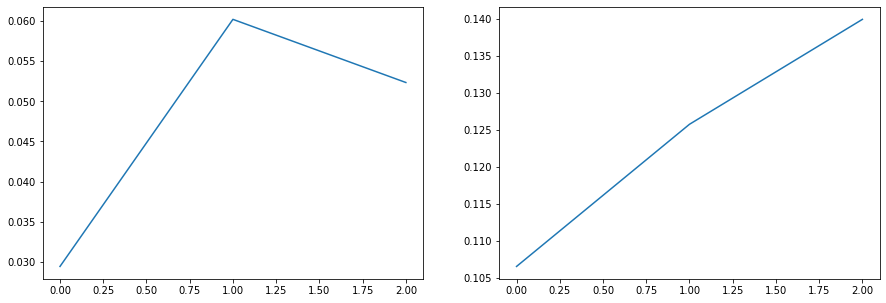

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot([tel_count[(True, i, True)]/(tel_count[(True, i, True)]+tel_count[(True, i, False)]) for i in range(3)])

plt.subplot(1, 2, 2)
plt.plot([tel_count[(False, i, True)]/(tel_count[(False, i, True)]+tel_count[(False, i, False)]) for i in range(3)])
#plt.plot([tel_count[(True, i, True)]/(tel_count[(True, i, True)]+tel_count[(True, i, False)]) for i in range(3)])
#plt.plot([tel_count[(True, i, True)]/(tel_count[(True, i, True)]+tel_count[(True, i, False)]) for i in range(3)])
plt.show()

In [13]:
print(stats.chi2_contingency([[tel_count[(False, 0, True)], tel_count[(False, 0, False)]],
                              [tel_count[(False, 2, True)], tel_count[(False, 2, False)]]]))

(1.237911215543786, 0.26587399357876595, 1, array([[  23.36814469,  145.63185531],
       [ 450.63185531, 2808.36814469]]))
